In [1]:
import pandas as pd

ddata = pd.read_csv("./data/ddata.txt", encoding="euc-kr", sep="\t", names=["num","speaker","contents","tags"])
mdata = pd.read_csv("./data/mdata.txt", encoding="euc-kr", sep="\t", names=["id","part","category","exptype","exp"])

ddata.head()

,num,speaker,contents,tags
0,0,<CO>,어서오세요. 코디봇입니다. 무엇을 도와드릴까요?,INTRO
1,1,<US>,처음 대학교 들어가는데 입을 옷 코디해주세요.,NaN
2,2,<CO>,신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요.,EXP_RES_SITUATION;EXP_RES_DESCRIPTION
3,3,<AC>,SW-009,NaN
4,4,<US>,이 옷에 어울리는 치마로 추천해주세요.,USER_SUCCESS


# 1. 전체 대화셋 개수 카운트

In [2]:
dial_num = 0

for i in range(1, len(ddata)):
    if ddata.loc[i, "num"] == 0:
        dial_num += 1
print("총 대화셋 수: ",dial_num)

총 대화셋 수:  7235


# 2. Mdata 합치기

## - Part 살려서 합치기

In [3]:
c_mdata = pd.DataFrame({"id":[0],"exp":[None]})
c_mdata.drop(0, axis=0, inplace=True)
c_mdata

,id,exp


In [4]:
id = ""
idx = 0
for i in range(len(mdata)):
    if id == mdata.loc[i, "id"]:
        c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] = c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] + " " + mdata.loc[i, "exp"]
    
    else:
        id = mdata.loc[i, "id"]
        c_mdata.loc[i, "id"] = id
        c_mdata.loc[i, "exp"] = mdata.loc[i, "exp"]

c_mdata.head()

,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
20,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
38,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
63,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
84,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


In [5]:
for i in range(len(c_mdata)): # id 뒤에 공백 없애기
    c_mdata.iloc[i].id = c_mdata.iloc[i].id.strip()

print(c_mdata.iloc[0].id)
c_mdata.reset_index(drop=True,inplace=True)
c_mdata.head()

BL-001


,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
1,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
2,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
3,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
4,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


# 3. NaN, Null 값 확인

In [6]:
ddata.drop(ddata.index[ddata.tags == "INTRO"].tolist(), axis=0, inplace=True)
ddata.reset_index(drop=True, inplace=True)
ddata[ddata.tags == "INTRO"]

,num,speaker,contents,tags


In [7]:
ddata.isnull().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [8]:
ddata.isna().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [9]:
ddata.fillna("", inplace=True)
ddata.isna().sum()

num         0
speaker     0
contents    0
tags        0
dtype: int64

In [10]:
mdata.isnull().sum()

id          0
part        0
category    0
exptype     0
exp         0
dtype: int64

In [11]:
c_mdata.isnull().sum()

id     0
exp    0
dtype: int64

# 4. 추천 성공 의상 아이디 종류 및 빈도 카운트 

## 한 번에 추천해도 실패하면 전부 실패로 달기

In [12]:
c_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
c_data.drop(0,axis=0,inplace=True)
c_data.head()

,contents,id


<코드 동작 원리>
<br>

대화문 하나씩 받아온 다음
- AC 태그 문장이면 일단 의상 변수에 저장,
- user_success 태그 문장이면

   - 변수에 저장된 의상이 하나면

      - 바로 대화문 변수랑 의상 변수 및 의상 메타데이터 합쳐서 저장 -> 레이블(id 컬럼에 저장)은 의상 코드가 됨

   - 변수에 저장된 의상의 여러 개면

      - 의상을 하나의 코드 단위로 쪼개서 대화문 변수랑 의상 메타데이터 합쳐서 저장
      
-  둘 다 아니고 일반 대화문이면 대화문 변수에 저장

In [13]:
dial = ddata.loc[0, "contents"].strip()
ac = ""

for i in range(1,len(ddata)):
    cur_sen = ddata.loc[i,"contents"].strip()

    if ddata.loc[i, "num"] > ddata.loc[i-1, "num"]: # 이전 대화셋에 포함된 문장인지 확인
        
        if ddata.loc[i,"speaker"] == "<AC>": # case 1. 의상 아이디가 나온 경우
            if len(ac) > 1:
                ac = ac + " " + cur_sen # 의상 아이디 저장
            else:
                ac = cur_sen

        elif "USER_SUCCESS" == ddata.loc[i,"tags"]: # case 2. USER_SUCCESS 태그가 나온 경우
            if 0 < len(ac) < 7: # 의상을 하나만 추천한 경우
                dial = dial + " " + ac + " " + cur_sen
                c_data.loc[i, "contents"] =  dial + " " + c_mdata.loc[c_mdata.id == ac].exp.values[0]
                c_data.loc[i, "id"] = ac
                ac = ""

            elif len(ac) == 0:
                dial = dial + " " + cur_sen

            else: # 의상을 한 번에 여러 개 추천한 경우
                idx_cnt = 0
                for one_ac in ac.split():
                    c_data.loc[i + idx_cnt, "contents"] =  dial + " " + one_ac + " "+ cur_sen + " " + c_mdata.loc[c_mdata.id == one_ac].exp.values[0]
                    c_data.loc[i + idx_cnt, "id"] = one_ac
                    idx_cnt += 1
                dial = dial + " " + ac + " " + cur_sen    
                ac = ""
        
        elif "USER_FAIL" in ddata.loc[i,"tags"]:
            dial = dial + " " + ac + " " + cur_sen
            ac = ""

        else: # case 3. 그냥 대화문인 경우
            dial = dial + " " + cur_sen
    
    else: #새로운 대화셋 시작이면 초기화
        dial = cur_sen
        ac = ""

In [14]:
print("전체 데이터 수: ", len(c_data))
c_data.head()

전체 데이터 수:  34303


,contents,id
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
12,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
17,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
22,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
26,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [15]:
c_data.reset_index(drop=True ,inplace=True)
c_data.head()

,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
1,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
2,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
4,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [16]:
c_data.loc[0].contents

'처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요. SW-009 이 옷에 어울리는 치마로 추천해주세요. 라운드 네크라인 여밈이 없는 풀오버 스타일 전체 케이블 조직 드롭숄더 슬리브 손등까지 오는 길이의 소매 몸에 적당히 맞는 품 엉덩이를 살짝 덮는 길이 네크라인, 소매 끝, 밑단에 고무단 처리 레이온52%,나일론20%,폴리에스터28% 꽈배기 조직, 플레인 조직이 섞여 있는 형태 드라이 크리닝 단색의 라임색 브라이트톤(고명도 고채도)의 옐로우 그린 산뜻하고 발랄한 느낌 기본의 단정한 편안한 산뜻한 발랄한 경쾌한 따뜻한 데일리룩 캠퍼스룩'

In [17]:
bl_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
bl_data.drop(0,axis=0,inplace=True)
bl_data.head()

,contents,id


In [18]:
for i in range(len(c_data)):
    if "BL" in c_data["id"][i][0:2]:
        bl_data = bl_data.append(c_data.iloc[i])

bl_data.reset_index(drop=True, inplace=True)
print("데이터 개수",len(bl_data))
bl_data.head()

데이터 개수 1970


,contents,id
0,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요. 고객님께서는 캐...,BL-054
1,남자친구와 기념일 데이트 하는데 여성스러운 데이트룩 추천해주세요. 기념일에 맞춰 사...,BL-046
2,친구들과 바다로 놀러가기로했어요. 어울리는 상의를 추천해주세요. 캐주얼하면서도 귀여...,BL-050
3,친구들과 바다로 놀러가기로했어요. 어울리는 상의를 추천해주세요. 캐주얼하면서도 귀여...,BL-050
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요. 여름 옷으로 보여주세요. 네...,BL-027


In [19]:
bl_data["contents"] = bl_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
bl_data.head()

<ipython-input-19-a8e9c8029809>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  bl_data["contents"] = bl_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,contents,id
0,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요 고객님께서는 캐주...,BL-054
1,남자친구와 기념일 데이트 하는데 여성스러운 데이트룩 추천해주세요 기념일에 맞춰 사랑...,BL-046
2,친구들과 바다로 놀러가기로했어요 어울리는 상의를 추천해주세요 캐주얼하면서도 귀여운 ...,BL-050
3,친구들과 바다로 놀러가기로했어요 어울리는 상의를 추천해주세요 캐주얼하면서도 귀여운 ...,BL-050
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요 여름 옷으로 보여주세요 네 그...,BL-027


In [20]:
bl_data["id"] = bl_data["id"].str.replace("[^0-9]","")

bl_data.head()

<ipython-input-20-adabc0dbfae6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  bl_data["id"] = bl_data["id"].str.replace("[^0-9]","")


,contents,id
0,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요 고객님께서는 캐주...,054
1,남자친구와 기념일 데이트 하는데 여성스러운 데이트룩 추천해주세요 기념일에 맞춰 사랑...,046
2,친구들과 바다로 놀러가기로했어요 어울리는 상의를 추천해주세요 캐주얼하면서도 귀여운 ...,050
3,친구들과 바다로 놀러가기로했어요 어울리는 상의를 추천해주세요 캐주얼하면서도 귀여운 ...,050
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요 여름 옷으로 보여주세요 네 그...,027


In [21]:
from collections import Counter
temp = bl_data["id"].tolist()
type_count = dict(Counter(temp))
type_count

{'054': 22,
 '046': 11,
 '050': 29,
 '027': 159,
 '005': 59,
 '055': 14,
 '016': 17,
 '053': 10,
 '022': 9,
 '018': 24,
 '013': 4,
 '037': 11,
 '041': 15,
 '036': 8,
 '048': 14,
 '006': 24,
 '021': 17,
 '003': 13,
 '038': 11,
 '042': 19,
 '025': 15,
 '007': 32,
 '009': 15,
 '052': 16,
 '028': 17,
 '015': 18,
 '010': 29,
 '004': 21,
 '031': 32,
 '029': 27,
 '002': 24,
 '032': 22,
 '051': 3,
 '056': 17,
 '034': 23,
 '017': 10,
 '026': 15,
 '024': 11,
 '047': 10,
 '057': 21,
 '012': 10,
 '040': 9,
 '019': 9,
 '014': 2,
 '008': 9,
 '011': 22,
 '001': 5,
 '039': 21,
 '043': 9,
 '020': 4,
 '030': 7,
 '049': 5,
 '059': 2,
 '060': 11,
 '033': 6,
 '094': 38,
 '073': 30,
 '135': 21,
 '119': 37,
 '138': 38,
 '089': 34,
 '072': 24,
 '137': 19,
 '088': 20,
 '113': 26,
 '101': 28,
 '061': 10,
 '064': 17,
 '071': 10,
 '118': 10,
 '112': 21,
 '096': 1,
 '111': 28,
 '125': 5,
 '127': 4,
 '074': 41,
 '128': 11,
 '103': 6,
 '090': 11,
 '092': 20,
 '108': 25,
 '044': 11,
 '120': 15,
 '114': 18,
 '087': 11

In [22]:
len(type_count)

142

In [23]:
del_list = []
for i in type_count.keys():
    if type_count.get(i) == 1:
        del_list.append(i)
del_list

['096', '132', '058', '066', '078', '080', '085', '136', '035']

In [24]:
bl_data.head()

,contents,id
0,친구들과 기차여행 가는데 편하고 활동성 좋은 여행복장 추천해주세요 고객님께서는 캐주...,054
1,남자친구와 기념일 데이트 하는데 여성스러운 데이트룩 추천해주세요 기념일에 맞춰 사랑...,046
2,친구들과 바다로 놀러가기로했어요 어울리는 상의를 추천해주세요 캐주얼하면서도 귀여운 ...,050
3,친구들과 바다로 놀러가기로했어요 어울리는 상의를 추천해주세요 캐주얼하면서도 귀여운 ...,050
4,카페에 알바를 가려고 하는데 면접 복장을 추천해주세요 여름 옷으로 보여주세요 네 그...,027


In [25]:
for i in del_list:
    bl_data = bl_data[bl_data["id"] != i]

In [26]:
len(bl_data)

1961

In [27]:
bl_data.reset_index(drop=True, inplace=True)

In [28]:
import matplotlib.pyplot as plt
plt.bar(Counter(bl_data.id).keys(),Counter(bl_data.id).values(), color='k')

<BarContainer object of 133 artists>

# 5. 형태소 분석

## Mecab 사용

In [29]:
from konlpy.tag import Mecab
mecab = Mecab()

In [30]:
mecab.morphs(bl_data["contents"][0])

['친구',
 '들',
 '과',
 '기차',
 '여행',
 '가',
 '는',
 '데',
 '편하',
 '고',
 '활동',
 '성',
 '좋',
 '은',
 '여행',
 '복장',
 '추천',
 '해',
 '주',
 '세요',
 '고객',
 '님',
 '께서',
 '는',
 '캐주얼',
 '한',
 '취향',
 '이',
 '시',
 '니',
 '원피스',
 '에',
 '이런',
 '스타일',
 '을',
 '매',
 '칭해',
 '보',
 '는',
 '걸',
 '추천',
 '해',
 '드려요',
 '마음',
 '에',
 '드',
 '시',
 '나요',
 'JP',
 '006',
 'OP',
 '083',
 'SE',
 '048',
 '원피스',
 '말',
 '고',
 '상의',
 '와',
 '반바지',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '상의',
 '와',
 '반바지',
 '를',
 '각각',
 '한꺼번에',
 '보여',
 '드릴게요',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '야외',
 '활동',
 '에',
 '부담없이',
 '입',
 '기',
 '좋',
 '은',
 '반바지',
 '스타일',
 '과',
 '시원',
 '해',
 '보이',
 '고',
 '휴양지',
 '느낌',
 '을',
 '주',
 '는',
 '바캉스',
 '룩',
 '의',
 '블라우스',
 '를',
 '추천',
 '해',
 '드립니다',
 'BL',
 '054',
 '둘',
 '다',
 '마음',
 '에',
 '드',
 '네요',
 '뒷',
 '지퍼',
 '여',
 '밈',
 '칼라',
 '가',
 '없',
 '는',
 '라운드',
 '네크라인',
 '셋',
 '인',
 '슬리브',
 '골반',
 '을',
 '살짝',
 '덮',
 '는',
 '기장',
 '팔꿈치',
 '위',
 '길이',
 '의',
 '일자',
 '형',
 '소매',
 '품',
 '이',
 '여유',
 '로운',
 '약간',
 '비침',
 '이',
 '있',
 '는',
 

In [31]:
len(bl_data)

1961

In [32]:
x_data = []
for i in range(len(bl_data)):
    x_data.append(mecab.morphs(bl_data["contents"][i]))

x_data[0]

['친구',
 '들',
 '과',
 '기차',
 '여행',
 '가',
 '는',
 '데',
 '편하',
 '고',
 '활동',
 '성',
 '좋',
 '은',
 '여행',
 '복장',
 '추천',
 '해',
 '주',
 '세요',
 '고객',
 '님',
 '께서',
 '는',
 '캐주얼',
 '한',
 '취향',
 '이',
 '시',
 '니',
 '원피스',
 '에',
 '이런',
 '스타일',
 '을',
 '매',
 '칭해',
 '보',
 '는',
 '걸',
 '추천',
 '해',
 '드려요',
 '마음',
 '에',
 '드',
 '시',
 '나요',
 'JP',
 '006',
 'OP',
 '083',
 'SE',
 '048',
 '원피스',
 '말',
 '고',
 '상의',
 '와',
 '반바지',
 '로',
 '추천',
 '해',
 '주',
 '세요',
 '상의',
 '와',
 '반바지',
 '를',
 '각각',
 '한꺼번에',
 '보여',
 '드릴게요',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '야외',
 '활동',
 '에',
 '부담없이',
 '입',
 '기',
 '좋',
 '은',
 '반바지',
 '스타일',
 '과',
 '시원',
 '해',
 '보이',
 '고',
 '휴양지',
 '느낌',
 '을',
 '주',
 '는',
 '바캉스',
 '룩',
 '의',
 '블라우스',
 '를',
 '추천',
 '해',
 '드립니다',
 'BL',
 '054',
 '둘',
 '다',
 '마음',
 '에',
 '드',
 '네요',
 '뒷',
 '지퍼',
 '여',
 '밈',
 '칼라',
 '가',
 '없',
 '는',
 '라운드',
 '네크라인',
 '셋',
 '인',
 '슬리브',
 '골반',
 '을',
 '살짝',
 '덮',
 '는',
 '기장',
 '팔꿈치',
 '위',
 '길이',
 '의',
 '일자',
 '형',
 '소매',
 '품',
 '이',
 '여유',
 '로운',
 '약간',
 '비침',
 '이',
 '있',
 '는',
 

In [33]:
stopwords = []
with open('./data/불용어사전.txt', mode='rt', encoding='utf-8') as f:
    for word in f.readlines():
        word = word.strip()
        stopwords.append(word)
stopwords[0:2]

['어찌됐든', '그위에']

In [34]:
X_data = []
for sentence in x_data: #문장 하나 가져오고 단어 단위로 쪼개기
    temp_X = [word for word in sentence if not word in stopwords] # 불용어 제거
    X_data.append(temp_X)
X_data[0]

['친구',
 '기차',
 '여행',
 '데',
 '편하',
 '고',
 '활동',
 '성',
 '좋',
 '여행',
 '복장',
 '추천',
 '주',
 '세요',
 '고객',
 '님',
 '께서',
 '캐주얼',
 '취향',
 '시',
 '니',
 '원피스',
 '스타일',
 '칭해',
 '보',
 '걸',
 '추천',
 '드려요',
 '마음',
 '시',
 '나요',
 'JP',
 '006',
 'OP',
 '083',
 'SE',
 '048',
 '원피스',
 '말',
 '고',
 '상의',
 '반바지',
 '추천',
 '주',
 '세요',
 '상의',
 '반바지',
 '한꺼번에',
 '보여',
 '드릴게요',
 '만',
 '기다려',
 '주',
 '세요',
 '야외',
 '활동',
 '부담없이',
 '입',
 '기',
 '좋',
 '반바지',
 '스타일',
 '시원',
 '보이',
 '고',
 '휴양지',
 '느낌',
 '주',
 '바캉스',
 '룩',
 '블라우스',
 '추천',
 '드립니다',
 'BL',
 '054',
 '둘',
 '다',
 '마음',
 '네요',
 '뒷',
 '지퍼',
 '밈',
 '칼라',
 '라운드',
 '네크라인',
 '셋',
 '인',
 '슬리브',
 '골반',
 '살짝',
 '덮',
 '기장',
 '팔꿈치',
 '위',
 '길이',
 '일자',
 '형',
 '품',
 '여유',
 '로운',
 '비침',
 '있',
 '윗부분',
 '주름',
 '잡',
 '아서',
 '볼륨',
 '줌',
 '안단',
 '있',
 '뒷',
 '중심',
 '절',
 '개선',
 '전체',
 '내추럴',
 '그린',
 '꽃무늬',
 '프린트',
 '면',
 '50',
 '레이온',
 '50',
 '평직',
 '비침',
 '있',
 '시원',
 '보이',
 '까슬까슬',
 '느낌',
 '구김',
 '기',
 '쉬운',
 '세로',
 '줄무늬',
 '보이',
 '드라이클리닝',
 '권',
 '장',
 '부드러운',
 '백',
 '아이보리',
 '컬

## 1. 임베딩 레이어 활용

### 정수 인코딩

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

In [36]:
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3546
등장 빈도가 5번 이하인 희귀 단어의 수: 1538
단어 집합에서 희귀 단어의 비율: 43.372814438804284
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.9316217067857682


In [37]:
vocab_size = total_cnt - rare_cnt + 1 # tokenizer 함수에 들어 갈 때 영향줘서 1 추가 해야 됨
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2009


케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,

케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에

배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

### 맨 앞자리는 비어있어야 함 (원 핫 인코딩은 정수 인코딩한 뒤 나오는 정수 값 자리에 1을 넣는 것)

In [38]:
tokenizer = Tokenizer(num_words=vocab_size - 1)
tokenizer.fit_on_texts(X_data)
len(tokenizer.word_index)

3546

In [39]:
X_data = tokenizer.texts_to_sequences(X_data) # 단어에 정수 붙여줄 때 num_word 적용

위에서 num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절

예를 들어서 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용

In [40]:
X_data[1]

[578,
 270,
 1732,
 130,
 321,
 24,
 20,
 130,
 26,
 12,
 1,
 3,
 1732,
 1085,
 193,
 292,
 47,
 847,
 103,
 2,
 316,
 130,
 26,
 4,
 13,
 6,
 21,
 32,
 229,
 476,
 8,
 644,
 74,
 612,
 27,
 607,
 340,
 330,
 363,
 51,
 84,
 287,
 1,
 3,
 102,
 24,
 292,
 7,
 157,
 9,
 11,
 454,
 801,
 61,
 8,
 822,
 177,
 9,
 24,
 20,
 11,
 32,
 5,
 10,
 1,
 3,
 319,
 82,
 89,
 24,
 477,
 1368,
 11,
 454,
 57,
 8,
 573,
 1059,
 210,
 51,
 52,
 603,
 590,
 33,
 255,
 34,
 652,
 207,
 29,
 1480,
 1530,
 236,
 145,
 176,
 286,
 283,
 43,
 48,
 115,
 312,
 48,
 146,
 212,
 44,
 67,
 64,
 183,
 184,
 153,
 70,
 9,
 265,
 97,
 64,
 277,
 227,
 531,
 176,
 313,
 314,
 41,
 38,
 2,
 15,
 25,
 290,
 9,
 55,
 40,
 213,
 127,
 112,
 110,
 86,
 234,
 126,
 22,
 70,
 177,
 271,
 319,
 24,
 20,
 15]

문장 최대 길이 : 359
문장의 평균 길이 : 184.3697093319735


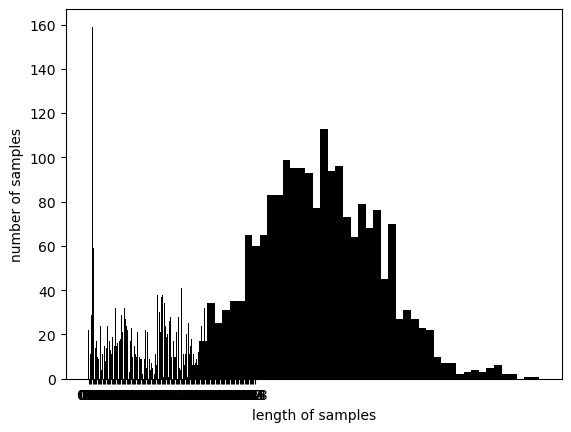

In [41]:
print('문장 최대 길이 :',max(len(l) for l in X_data))
print('문장의 평균 길이 :',sum(map(len, X_data))/len(X_data))
plt.hist([len(s) for s in X_data], bins=50, color='k')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.close()

In [42]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, X_data)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 98.62315145334013


## padding

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_data = pad_sequences(X_data, maxlen = max_len)

In [44]:
print(len(X_data[1]))
X_data[1]

300


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# 6. LSTM 돌리기 

In [45]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [46]:
X = X_data
y = bl_data.id.tolist()

In [47]:
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [48]:
y[1]

'046'

In [49]:
print(len(X),len(y))

1961 1961


In [50]:
y = to_categorical(y)

In [51]:
print(X.shape, y.shape)

(1961, 300) (1961, 149)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=777, stratify=y) #추천 한 번밖에 안된 애들 있어서 stratify 안됨

In [53]:
num_class = int(max(bl_data.id)) + 1

In [54]:
from tensorflow.keras.layers import SimpleRNN

In [55]:
model = Sequential()
model.add(Embedding(vocab_size, max_len))
model.add(SimpleRNN(max_len))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         602700    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 300)               180300    
_________________________________________________________________
dense (Dense)                (None, 149)               44849     
Total params: 827,849
Trainable params: 827,849
Non-trainable params: 0
_________________________________________________________________


In [56]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('bl_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.2)

print("테스트 셋 체크")
loaded_model = load_model('bl_model_lstm.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

Epoch 1/10
35/35 [==============================] - 14s 375ms/step - loss: 3.7414 - acc: 0.5553 - val_loss: 1.7481 - val_acc: 0.9127

Epoch 00001: val_acc improved from -inf to 0.91273, saving model to bl_model_lstm.h5
Epoch 2/10
35/35 [==============================] - 13s 367ms/step - loss: 1.1090 - acc: 0.9765 - val_loss: 0.5951 - val_acc: 0.9564

Epoch 00002: val_acc improved from 0.91273 to 0.95636, saving model to bl_model_lstm.h5
Epoch 3/10
35/35 [==============================] - 14s 386ms/step - loss: 0.3119 - acc: 0.9929 - val_loss: 0.3425 - val_acc: 0.9818

Epoch 00003: val_acc improved from 0.95636 to 0.98182, saving model to bl_model_lstm.h5
Epoch 4/10
35/35 [==============================] - 13s 374ms/step - loss: 0.1323 - acc: 0.9991 - val_loss: 0.2289 - val_acc: 0.9818

Epoch 00004: val_acc did not improve from 0.98182
Epoch 5/10
35/35 [==============================] - 13s 374ms/step - loss: 0.0596 - acc: 1.0000 - val_loss: 0.1730 - val_acc: 0.9818

Epoch 00005: val_ac

Cannot convert a symbolic Tensor -> numpy 버전 1.19.5로 바꿔줌

https://wikidocs.net/45101

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


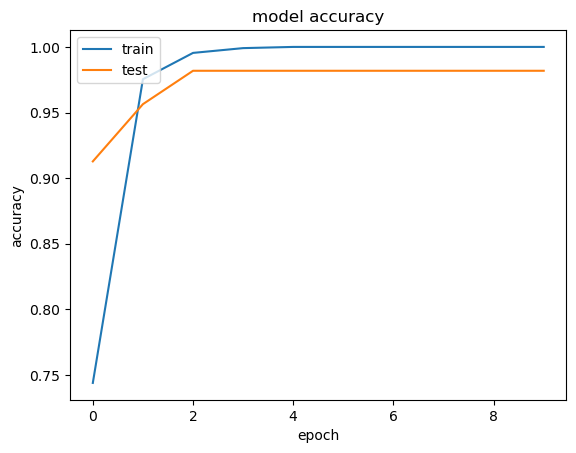

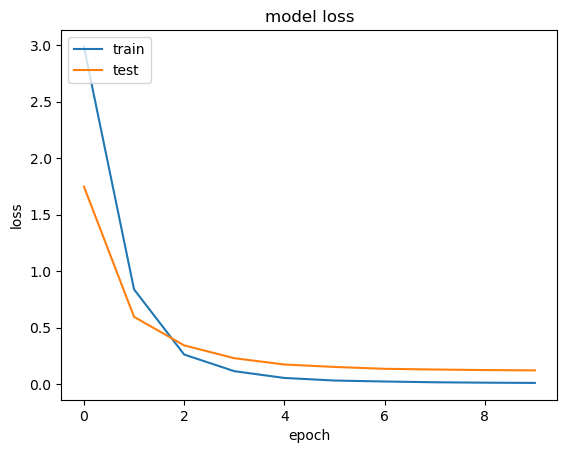

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()